# Energies and logits for experimental dataset

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import json

from scipy.stats import pearsonr, spearmanr

import torch
import torch.nn as nn
import torch.nn.functional as F

import logomaker

from NegativeClassOptimization import ml, visualisations
from NegativeClassOptimization import config, utils
from NegativeClassOptimization import preprocessing, datasets
import utils_07

/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/eugen/miniconda3/envs/nco/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [9]:
def get_energy_logits_df(fp, fp_test_1, fp_test_2):

    df_test_1 = pd.read_csv(fp_test_1, sep="\t")
    df_test_1["class"] = "positive"
    df_test_2 = pd.read_csv(fp_test_2, sep="\t")
    df_test_2["class"] = "negative"
    df_test = pd.concat([df_test_1, df_test_2], axis=0)

    with open(fp, "r") as f:
        data = json.load(f)
    df = pd.DataFrame.from_records(data)

    df_kd = pd.read_csv("01b_df_kd.csv")


    df = pd.merge(df, df_test, left_on="slide", right_on="Slide")
    df = pd.merge(df, df_kd, left_on="slide", right_on="cdr3", how="left")
    return df


paths = {
    "vs Weak": {
        "fp": "../data/Frozen_MiniAbsolut_ML/high_vs_looser/seed_0/split_42/HR2P_high__vs__HR2P_looser/attributions/v2.0-2/attribution_records.json",
        "fp_test_1": "../data/MiniAbsolut/HR2P/high_test_500.tsv",
        "fp_test_2": "../data/MiniAbsolut/HR2P/looserX_test_500.tsv",
    },

    "vs Non-binder": {
        "fp": "../data/Frozen_MiniAbsolut_ML/high_vs_95low/seed_0/split_42/HR2P_high__vs__HR2P_95low/attributions/v2.0-2/attribution_records.json",
        "fp_test_1": "../data/MiniAbsolut/HR2P/high_test_500.tsv",
        "fp_test_2": "../data/MiniAbsolut/HR2P/95low_test_500.tsv",
    },

    "vs Randomized": {
        "fp": "../data/Frozen_MiniAbsolut_ML/1v1/seed_0/split_42/HR2P__vs__HR2PIR/attributions/v2.0-2/attribution_records.json",
        "fp_test_1": "../data/MiniAbsolut/HR2P/high_test_500.tsv",
        "fp_test_2": "../data/MiniAbsolut/HR2PSR/high_test_5000.tsv",
    },
    
}

,slide,logits,expits,y_pred,y_true,is_pred_correct,DeepLIFT_LOCAL_v2.0-2,DeepLIFT_GLOBAL_R10_v2.0-2,exec_time,Unnamed: 0_x,...,intensity 2,intensity 3,intensity 4,intensity 5,intensity 6,intensity 7,intensity 8,intensity 9,affinity_est,task
0,HDTGYCDSSRCLTWPEYFQHW,9.470077,0.999923,1,1,True,"[[0.0, 0.00075069087324664, 0.0018600795883685...","[[0.1029399037361145, -0.0008842707611620426, ...",191.271252,3762,...,120.648466,118.161326,130.462741,158.765007,209.476718,208.598083,214.569535,187.383495,2.466009e+07,vs Weak
1,HDTGWCDDSNCAKWPEYFQHW,8.520284,0.999801,1,1,True,"[[-0.011101613752543926, -0.002190264407545328...","[[0.1096981018781662, 0.011974796652793884, -0...",191.271252,3758,...,112.542651,117.557295,124.954847,145.895140,175.085066,208.002342,187.880012,179.893261,6.870290e+06,vs Weak
2,HDTAYCDTPRCAKWPEYFQHW,8.360267,0.999766,1,1,True,"[[0.0, 0.0, 0.0, 0.0, -0.03196832537651062, 0....","[[0.12173209339380264, -0.007481561042368412, ...",191.271252,3680,...,111.104172,113.197650,121.630337,137.500582,170.312209,200.195138,190.295336,177.730149,9.866161e+06,vs Weak
3,HDVGYCDTPTCASWPEYFQHW,8.337541,0.999761,1,1,True,"[[0.0, 0.0, 0.0003540836332831532, 0.0, -0.016...","[[0.10983041673898697, -0.015131634660065174, ...",191.271252,17654,...,116.154006,122.793758,135.698840,160.892841,192.324927,203.721256,191.848364,182.036794,9.687003e+06,vs Weak
4,HDVGFCDTPTCAKWPEYFQHW,7.975132,0.999656,1,1,True,"[[-0.011828131973743439, 0.0006424520397558808...","[[0.11491819471120834, -0.012472284026443958, ...",191.271252,11002,...,112.160130,117.758093,127.454716,149.616884,179.069848,200.615099,189.036348,181.414487,7.574416e+06,vs Weak


In [11]:
fp = Path("../data/Frozen_MiniAbsolut_ML/LogitEnergyCorrelations_Exp_Scatter.tsv")

if not fp.exists():
    dfs = []
    for i, (task_i, paths_i) in enumerate(paths.items()):

        df_i = get_energy_logits_df(paths_i["fp"], paths_i["fp_test_1"], paths_i["fp_test_2"])
        df_i["task"] = task_i
        dfs.append(df_i)

    df = pd.concat(dfs, axis=0)
    df.to_csv(fp, sep="\t", index=False)
else:
    df = pd.read_csv(fp, sep="\t")

vs Weak: p-val: 3.931119746842875e-264, r: 0.84
vs Non-binder: p-val: 5.417917299663788e-243, r: 0.82
vs Randomized: p-val: 0.3565597501317509, r: -0.05


/tmp/ipykernel_51664/3510828252.py:18: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_51664/3510828252.py:18: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(
/tmp/ipykernel_51664/3510828252.py:18: UserWarning: The palette list has more values (3) than needed (1), which may not be intended.
  sns.scatterplot(


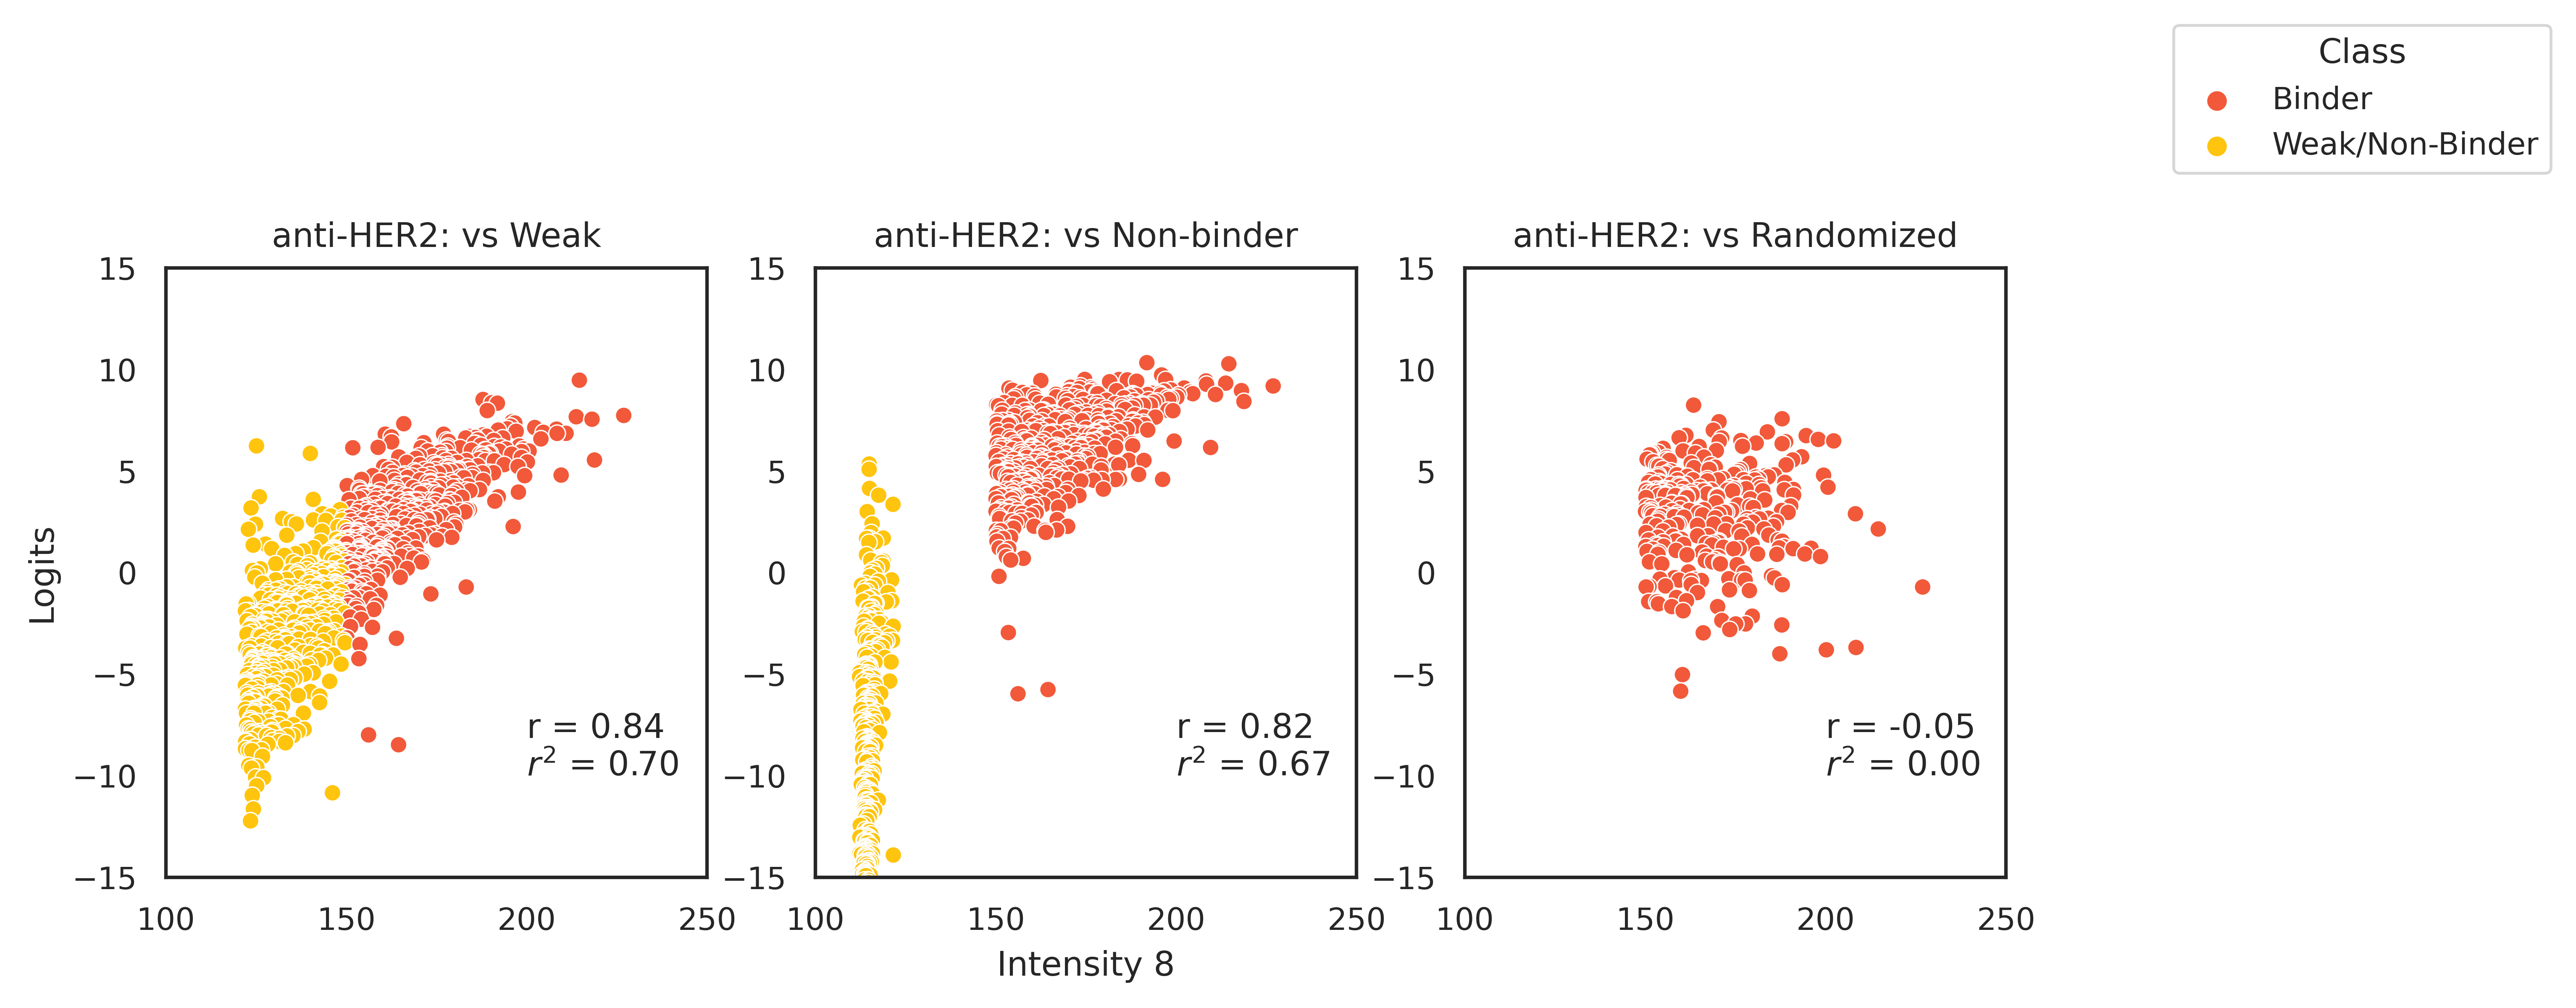

In [12]:
fig, axs = plt.subplots(ncols=3, figsize=(3*3.14, 3.14), dpi=600)
sns.set_theme(context="paper")
sns.set_style("white")

col_to_corr = "intensity 8"

cmap = [
    "#f1593a", # red
    "#ffc40d", # yellow
    "#28a3dc", # blue
]

for i, (task_i, paths_i) in enumerate(paths.items()):

    df_i = df.loc[df["task"] == task_i]
    ax = axs[i]

    sns.scatterplot(
        data=df_i,
        x=col_to_corr,
        y="logits",
        hue="class",
        ax=ax,
        palette=cmap,
    )

    ax.set_xlim((100, 250))
    ax.set_ylim((-15, 15))

    ax.set_xlabel("")
    ax.set_ylabel("")
    
    if i == 1:
        ax.set_xlabel("Intensity 8")
    if i == 0:
        ax.set_ylabel("Logits")
    
    ax.set_title(f"anti-HER2: {task_i}")
    # ax.set_xticks(np.arange(-110, -89, 5))

    # Add a coefficient of correlation and coeficient of determination
    r, p = pearsonr(
        df_i[col_to_corr].loc[df_i[col_to_corr].notna()], 
        df_i["logits"].loc[df_i[col_to_corr].notna()],
        )
    print(f"{task_i}: p-val: {p}, r: {r:.2f}")
    r2 = r ** 2
    ax.text(
        200,
        -10,
        f"r = {r:.2f}\n$r^2$ = {r2:.2f}",
        bbox=dict(facecolor="white", alpha=0.5),
    )
    # Remove legend from ax
    ax.get_legend().remove()

# Add legend with legend title
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles=handles,
    labels=["Binder", "Weak/Non-Binder"],
    title="Class",
    loc="lower center",
    bbox_to_anchor=(1.05, 1),
    borderaxespad=0,
)

Correlations of attributions between tasks

In [13]:
from utils_07 import get_attr_from_records, get_onehotstack_from_records
from utils_07 import load_energy_contributions_from_task_nonlinear_version

In [14]:
task_types= [
    datasets.ClassificationTaskType.ONE_VS_ONE,
    datasets.ClassificationTaskType.HIGH_VS_95LOW,
    datasets.ClassificationTaskType.HIGH_VS_LOOSER,
]

loader = datasets.FrozenMiniAbsolutMLLoader(
    data_dir=Path("../data/Frozen_MiniAbsolut_ML/")
)

FORCE_RUN = False
df_path = Path("../data/Frozen_MiniAbsolut_ML/LogitEnergy_Correlations_Exp.csv")

if df_path.exists() and not FORCE_RUN:
    df = pd.read_csv(df_path)
else:
    seed_id = 0
    split_id = 42
    attributor_name = "DeepLIFT_LOCAL_v2.0-2"
    dfs = []
    for ag in ["HR2P"]:
        
        df = pd.DataFrame()
        for task_type in task_types:   

            if task_type == datasets.ClassificationTaskType.ONE_VS_ONE:
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag,
                    ag_neg="HR2PSR",
                    seed_id=seed_id,
                    split_id=split_id,
                )
            else:
                task = datasets.ClassificationTask(
                    task_type=task_type,
                    ag_pos=ag,
                    ag_neg="auto",
                    seed_id=seed_id,
                    split_id=split_id,
                )
            
            task = loader.load(task, attributions_toload="v2.0-2", load_model=True)

            attr_stack = get_attr_from_records(
                task.attributions, attributor_name, (0, 1)  # type: ignore
            )  # Nx11x20 # type: ignore
            onehot_stack = get_onehotstack_from_records(
                task.attributions, (0, 1)  # type: ignore
            )  # Nx220 # type: ignore
            attr_aa = attr_stack[onehot_stack.reshape((-1, 21, 20)) == 1].reshape(
                -1, 21
            )  # Nx11

            
            df_i = pd.DataFrame.from_records(task.attributions)
            df_i["ag"] = ag
            col_aa = f"attr_aa_{task.task_type.to_str()}"
            col_logits = f"logits_{task.task_type.to_str()}"
            df_i[col_aa] = [arr for arr in attr_aa]
            df_i[col_logits] = df_i["logits"]
            

            df_i.query("y_true == 1", inplace=True)
            df_i = df_i[["slide", "ag", col_aa, col_logits, "L1_complexity", "L2_complexity", "SN10_complexity"]]

            if df.shape[0] == 0:
                df = df_i
            else:
                df = pd.merge(df, df_i, on=["slide", "ag"], how="inner")
        dfs.append(df)

    df = pd.concat(dfs, axis=0)
    df = df.reset_index(drop=True)
    df.to_csv(df_path, index=False)

In [15]:
def process_str_to_list_floats(s):
    vals = []
    for ch in s.replace("\n", "").strip("[] ").split(" "):
        if ch == "":
            continue
        vals.append(float(ch))
    assert len(vals) == 21
    return vals

if type(df["attr_aa_high_vs_looser"][0][0]) is not np.float64:
    df["attr_aa_high_vs_looser"] = df["attr_aa_high_vs_looser"].apply(process_str_to_list_floats) 
    df["attr_aa_high_vs_95low"] = df["attr_aa_high_vs_95low"].apply(process_str_to_list_floats)
    df["attr_aa_1v1"] = df["attr_aa_1v1"].apply(process_str_to_list_floats)

In [16]:
df["corr_attr_losser_95low"] = df.apply(lambda row: pearsonr(row["attr_aa_high_vs_looser"], row["attr_aa_high_vs_95low"])[0], axis=1)
df["corr_attr_9_looser"] = df.apply(lambda row: pearsonr(row["attr_aa_1v1"], row["attr_aa_high_vs_looser"])[0], axis=1) 
df["corr_attr_9_95low"] = df.apply(lambda row: pearsonr(row["attr_aa_1v1"], row["attr_aa_high_vs_95low"])[0], axis=1)

In [17]:
# Melt df across correlations
df_corr = df[["slide", "ag", "corr_attr_losser_95low", "corr_attr_9_looser", "corr_attr_9_95low"]]  # "L1_complexity", "L2_complexity", "SN10_complexity"
df_corr = df_corr.melt(id_vars=["slide", "ag"], var_name="corr_type", value_name="corr_value")
df_corr

,slide,ag,corr_type,corr_value
0,HDVGYCDTPNCAKWPEYFQHW,HR2P,corr_attr_losser_95low,0.419568
1,HDVGQCDTPTCAKWPEYFQHW,HR2P,corr_attr_losser_95low,0.450543
2,HDVGYCSSSRCATWPEYFQHW,HR2P,corr_attr_losser_95low,0.451795
3,HDVGYCDSSRCLTWPEYFQHW,HR2P,corr_attr_losser_95low,0.357278
4,HDVGYCSSPRCLTWPEYFQHW,HR2P,corr_attr_losser_95low,0.342386
...,...,...,...,...
1495,HDVDYCSDLRCLTWPEYFKFW,HR2P,corr_attr_9_95low,0.555423
1496,HEVAYCDTPTCDDWDEYFQHW,HR2P,corr_attr_9_95low,0.143249
1497,HDVDHCESDRCLTWPEYLQHW,HR2P,corr_attr_9_95low,0.367946
1498,HDVGDCDSDDCAMWPEYFCHW,HR2P,corr_attr_9_95low,0.656729


In [18]:
map_to_clean = {
    "corr_attr_losser_95low": "vs Weak - vs Non-binder",
    "corr_attr_9_looser": "vs Randomized - vs Weak",
    "corr_attr_9_95low": "vs Randomized - vs Non-binder",

}
df_corr["corr_type_clean"] = df_corr["corr_type"].apply(
    lambda s: map_to_clean[s]
)

Text(0, 0.5, 'Pearson correlation coefficient')

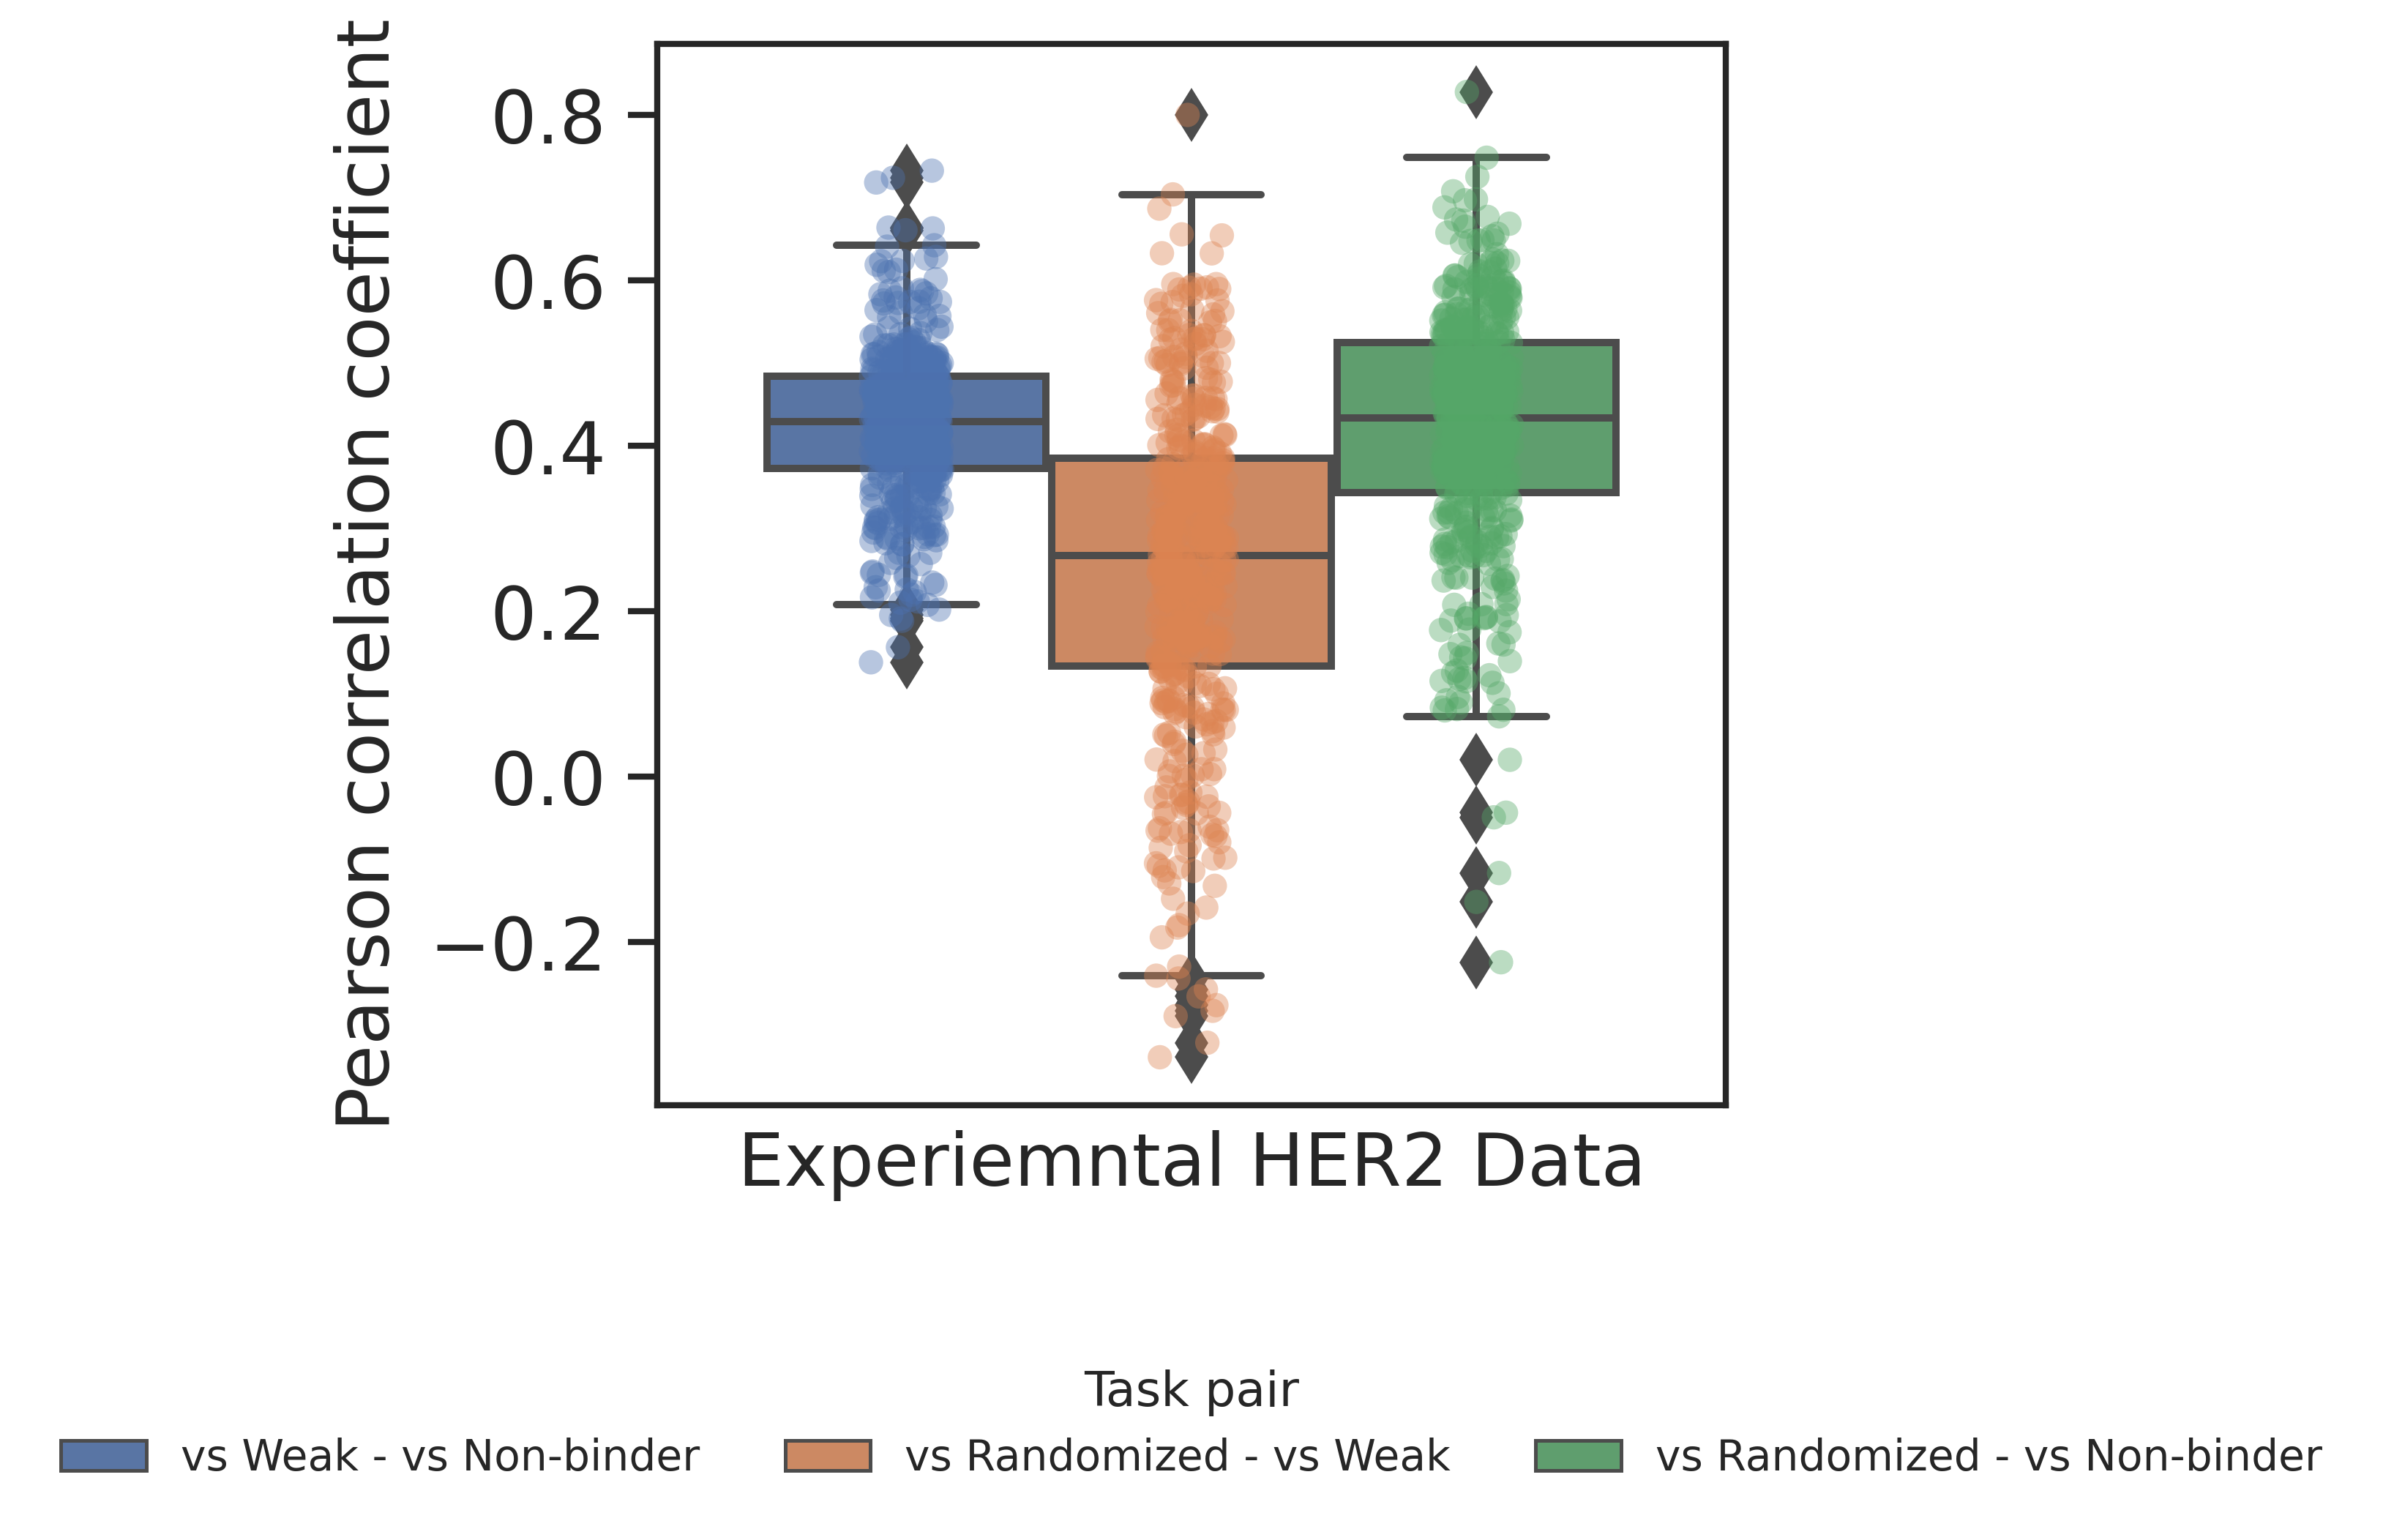

In [20]:
plt.rcParams['svg.fonttype'] = 'none' #saves text as text not object
sns.set_style("white")
sns.set_style('ticks')

fig, ax = plt.subplots(figsize=(3.14, 3.14), dpi=600)

sns.boxplot(
    data=df_corr,
    x="ag",
    y="corr_value",
    hue="corr_type_clean",
    ax=ax,
)

sns.stripplot(
    x="ag",
    y="corr_value",
    hue="corr_type_clean",
    data=df_corr,
    ax=ax,
    alpha=0.4,
    dodge=True,
    size=4,
    legend=False, # type: ignore
)

# visualisations.add_median_labels(ax, y_level=-0.2, fontsize=7)

ax.tick_params(labelsize=12)
ax.legend(
    bbox_to_anchor=(0.5, -0.3),
    loc="center",
    borderaxespad=0.0,
    fontsize=7,
    title="Task pair",
    title_fontsize=8,
    ncol=10,
    frameon=False,
)

ax.set_xticks([])

ax.set_xlabel("Experiemntal HER2 Data", fontsize=12)
ax.set_ylabel("Pearson correlation coefficient", fontsize=12)
